# Test 22 part 3

Making the cool figures

In [2]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [4]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = quench_time + evolution_time
sim_path = "/mnt/e/rotBField/data/test22"
data_path = "../data/test22p3/"

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)

params['mu0'] = (4*np.pi)*1e-7 * ureg.H/ureg.m
params['m'] = np.pi * (2*params['particle_radius'])**3 *params['particle_susceptibility']*params['max_field']/6/params['mu0']
params['kb'] = 1.380649e-23 * ureg.J / ureg.K
params['kbT'] = (params['kb'] * params['sim_temp']).to(ureg.nm * ureg.pN)

## Computing $r_\parallel$

Do not run this cell like a fool

In [4]:
ctrj = pd.read_csv(os.path.join(sim_path,'30','ctrj','ctrj1.csv'), index_col=[0,1])
particles = ctrj.index.get_level_values('id').unique().to_list()
frames = ctrj.index.get_level_values('frame').unique().to_list()
sframes = frames[::5]

# Computing the rparallel timeseries

ts = []

for pi in particles:
    print(f"Particle {pi}")

    single_ts = [aux.get_rparalell(ctrj,pi,frame) for frame in sframes]
    ts.append(single_ts)
    
    clear_output(wait=True)


df = pd.DataFrame(data= np.array(ts), columns=sframes)


## Correlations

In [5]:
ts = pd.read_csv(os.path.join(data_path,'rparallel.csv'), index_col=0)
sframes = [int(i) for i in ts.columns]
ts = ts.to_numpy()

In [ ]:
h = 20
[(0,h)] +[(n*h,(n+1)*h) for n in range(1,int(300/h))]

In [33]:
h = 20
intervals = [(0, 20),
 (20, 40),
 (40, 60),
 (60, 80),
 (80, 100),
 #(100, 120),
 #(120, 140),
 #(140, 160),
 (160, 180),
 #(180, 200),
 #(200, 220),
 (220, 240),
 #(240, 260),
 #(260, 280),
 (280, 300)]

corr_averages = []
corr_stds = []
frames = []
for (s,e) in intervals:
    
    subselframes, correlations = aux.correlate_bframes(params,ts,sframes,stime=s,etime=e)
    corrav = np.mean(np.array(correlations),axis=0)
    corrstd = np.std(np.array(correlations),axis=0)
    
    corr_averages.append(corrav)
    corr_stds.append(corrstd)
    frames.append(subselframes - subselframes[0])
    
ncorr = [x/np.max(x) for x in corr_averages]

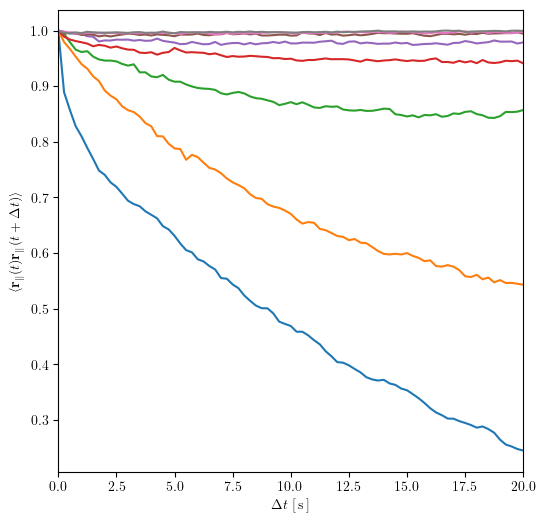

In [37]:
fig, ax = plt.subplots(figsize = (6,6))

for (f,c) in zip(frames, ncorr):
    ax.plot(f/params['framespersec'].magnitude ,c)

ax.set_xlabel("$\\Delta t$ [\,s\,]")
ax.set_ylabel("$\\langle \mathbf{r}_\parallel(t) \mathbf{r}_\parallel(t+\\Delta t)\\rangle$")

ax.set_xlim(0,h)
#ax.set_ylim(0,1)

fig.savefig(os.path.join(data_path,'fig4','correlations.png'),dpi=300,bbox_inches='tight')

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy